# Predicting 2024 US Corn Yield

In [116]:
# Importing necessary libraries
import requests
import time
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.utils import resample
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

## Data Acquisition

For data acquisition, I have decided to download the data directly from the [API](https://quickstats.nass.usda.gov/api) of [United States Department of Agriculture](https://quickstats.nass.usda.gov/). <br>
Then I wrote some code to download the data for each year and then, merge it in a uniqe .csv file. Skip this part if you download/have the data already for each year.

In [117]:
# # I have stored the API key in a file named 'API_key.txt' for security reasons.
# # Reading the API key from a file
# with open('./data/API_key.txt') as f:
#     api_key = f.read()

In [118]:
# # Setting up API parameters
# API_KEY = api_key
# BASE_URL = 'http://quickstats.nass.usda.gov/api/api_GET/'
# OUTPUT_DIR = 'corn_yield_csv'
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# # Select years for collection
# START_YEAR = 1910
# END_YEAR = 2024

# for year in range(START_YEAR, END_YEAR + 1):
#     params = {
#         'key': API_KEY,
#         'commodity_desc': 'CORN',
#         'statisticcat_desc': 'YIELD',
#         'unit_desc': 'BU / ACRE',
#         'agg_level_desc': 'COUNTY',
#         'year': year,
#         'format': 'JSON'
#     }

#     try:
#         print(f"Downloading data for year {year}...")
#         response = requests.get(BASE_URL, params=params)
#         response.raise_for_status()
#         data = response.json()

#         records = data.get('data', [])
#         if not records:
#             print(f"No data for {year}, next.")
#             continue

#         df = pd.DataFrame(records)

#         # Saving the DataFrame to a CSV file
#         csv_path = os.path.join(OUTPUT_DIR, f"corn_yield_{year}_county.csv")
#         df.to_csv(csv_path, index=False)
#         print(f"Saved {csv_path} with {len(df)} record.")
#         time.sleep(3)  

#     except requests.exceptions.RequestException as e:
#         print(f"Error for year {year}: {e}")
#         time.sleep(5)

In [119]:
# # Assembling all .csv files into a single dataset
# INPUT_DIR = 'corn_yield_csv'
# OUTPUT_FILE = './data/corn_yield_all_years_county.csv'

# files = [os.path.join(INPUT_DIR, f) for f in os.listdir(INPUT_DIR) if f.endswith('.csv')]
# dfs = []

# for file in sorted(files):
#     print(f"Loading {file}...")
#     df = pd.read_csv(file)

#     # clean the 'Value' column for consistency
#     def clean_value(val):
#         try:
#             return float(str(val).replace(",", ""))
#         except:
#             return None
#     df['Value'] = df['Value'].apply(clean_value)

#     dfs.append(df)

# if dfs:
#     full_df = pd.concat(dfs, ignore_index=True)
#     full_df.to_csv(OUTPUT_FILE, index=False)
#     print(f"Dataset complete saved in '{OUTPUT_FILE}'.")
# else:
#     print("There are no files to assemble")

## Data Sanity Check and Exploratory Data Analysis

### Yield Data

In [120]:
# Reading the assembled dataset
df = pd.read_csv('./data/corn_yield_all_years_county.csv')

In [121]:
# Displaying basic statistics of the dataset
df.describe()

,region_desc,state_fips_code,country_code,state_ansi,week_ending,county_code,county_ansi,congr_district_code,end_code,begin_code,Value,watershed_desc,watershed_code,CV (%),year,zip_5,asd_code
count,0.0,221557.000000,221557.0,221557.000000,0.0,221557.000000,213879.000000,0.0,221557.0,221557.0,221557.000000,0.0,221557.0,7506.000000,221557.000000,0.0,221557.000000
mean,NaN,30.088032,9000.0,30.088032,NaN,124.446865,93.087353,NaN,0.0,0.0,81.044844,NaN,0.0,5.555622,1978.090415,NaN,49.885844
std,NaN,13.262452,0.0,13.262452,NaN,179.477601,70.645899,NaN,0.0,0.0,48.957053,NaN,0.0,4.511936,25.600817,NaN,25.498104
min,NaN,1.000000,9000.0,1.000000,NaN,1.000000,1.000000,NaN,0.0,0.0,0.000000,NaN,0.0,0.500000,1910.000000,NaN,10.000000
25%,NaN,20.000000,9000.0,20.000000,NaN,41.000000,39.000000,NaN,0.0,0.0,40.000000,NaN,0.0,2.700000,1960.000000,NaN,30.000000
50%,NaN,29.000000,9000.0,29.000000,NaN,87.000000,83.000000,NaN,0.0,0.0,73.600000,NaN,0.0,4.100000,1980.000000,NaN,50.000000
75%,NaN,39.000000,9000.0,39.000000,NaN,139.000000,133.000000,NaN,0.0,0.0,114.600000,NaN,0.0,6.900000,1998.000000,NaN,70.000000
max,NaN,56.000000,9000.0,56.000000,NaN,998.000000,810.000000,NaN,0.0,0.0,296.300000,NaN,0.0,63.400000,2024.000000,NaN,99.000000


In [122]:
# Renaming the 'Value' column to 'Yield' for clarity
df.rename(columns={'Value': 'Yield'}, inplace=True)

Many columns are redundant or irrelevant to the task, so I have decided to select a subset of columns for further analysis.

In [123]:
df.columns

Index(['source_desc', 'region_desc', 'group_desc', 'agg_level_desc',
       'state_name', 'country_name', 'statisticcat_desc', 'domaincat_desc',
       'state_fips_code', 'country_code', 'sector_desc', 'state_ansi',
       'week_ending', 'county_code', 'prodn_practice_desc', 'county_ansi',
       'reference_period_desc', 'congr_district_code', 'unit_desc', 'end_code',
       'asd_desc', 'load_time', 'begin_code', 'Yield', 'domain_desc',
       'util_practice_desc', 'watershed_desc', 'short_desc', 'watershed_code',
       'class_desc', 'commodity_desc', 'freq_desc', 'county_name', 'CV (%)',
       'state_alpha', 'location_desc', 'year', 'zip_5', 'asd_code'],
      dtype='object')

In [124]:
# Defining interest columns 
interest_columns = ['year','country_name','state_name','county_name','Yield']

In [125]:
# Selecting only the interest columns
df = df.loc[:, interest_columns]

In [126]:
# Looking for missing values. The data seems to be clean, but let's check.
df.isna().sum()

year            0
country_name    0
state_name      0
county_name     0
Yield           0
dtype: int64

In [127]:
# Aggregation for state and year
year_state_mean = df.groupby(['year', 'state_name'])['Yield'].mean().reset_index()

In [128]:
# Aggregation for national average
year_mean = df.groupby(['year'])['Yield'].mean().reset_index()

In [129]:
# Plotting the start and end year for each state. Some states do not have data for all years.
state_year_range = year_state_mean.groupby('state_name')['year'].agg(['min', 'max'])
print(state_year_range)


                 min   max
state_name                
ALABAMA         1939  2024
ARIZONA         1965  2008
ARKANSAS        1961  2024
CALIFORNIA      1959  2023
COLORADO        1963  2024
DELAWARE        1928  2024
FLORIDA         1961  2009
GEORGIA         1954  2024
IDAHO           1972  2024
ILLINOIS        1925  2024
INDIANA         1929  2024
IOWA            1926  2024
KANSAS          1958  2024
KENTUCKY        1929  2024
LOUISIANA       1959  2024
MARYLAND        1928  2024
MICHIGAN        1942  2024
MINNESOTA       1921  2024
MISSISSIPPI     1953  2024
MISSOURI        1919  2024
MONTANA         1944  2016
NEBRASKA        1910  2024
NEW JERSEY      1953  2016
NEW MEXICO      1956  2016
NEW YORK        1972  2024
NORTH CAROLINA  1925  2024
NORTH DAKOTA    1919  2024
OHIO            1918  2024
OKLAHOMA        1933  2024
OREGON          1956  2009
PENNSYLVANIA    1960  2024
SOUTH CAROLINA  1944  2024
SOUTH DAKOTA    1924  2024
TENNESSEE       1955  2024
TEXAS           1968  2024
U

In [130]:
# Displaying the first few rows of the full dataset
df.head()

,year,country_name,state_name,county_name,Yield
0,1910,UNITED STATES,NEBRASKA,BANNER,14.4
1,1910,UNITED STATES,NEBRASKA,BOX BUTTE,16.0
2,1910,UNITED STATES,NEBRASKA,CHEYENNE,9.6
3,1910,UNITED STATES,NEBRASKA,DAWES,16.4
4,1910,UNITED STATES,NEBRASKA,DEUEL,17.5


In [131]:
# Check if the yield daya is influenced by the value of the previous year
df['Yield_lag1'] = df['Yield'].shift(1)
df.dropna(inplace=True)

correlation= df['Yield'].corr(df['Yield_lag1'])
print(f"Correlation with previous year: {correlation:.2f}")


Correlation with previous year: 0.91


Yield values exhibit a strong year-to-year correlation, indicating that high yields are typically followed by similarly high yields, while low yields tend to persist. This consistent pattern reflects temporal persistence, making past yields a useful predictor of future performance.

In [132]:
# Group by state to get average yield across all years
state_avg_yield = df.groupby('state_name')['Yield'].mean().reset_index()

In [133]:
# First 5 states with the highest average yield
state_avg_yield.sort_values(by='Yield', ascending=False).head(5)

,state_name,Yield
8,IDAHO,129.907670
3,CALIFORNIA,119.936595
35,UTAH,111.171765
24,NEW YORK,109.179003
1,ARIZONA,107.542978


### Visualization of the Yield data

Using the Shapefile of state boundaries: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

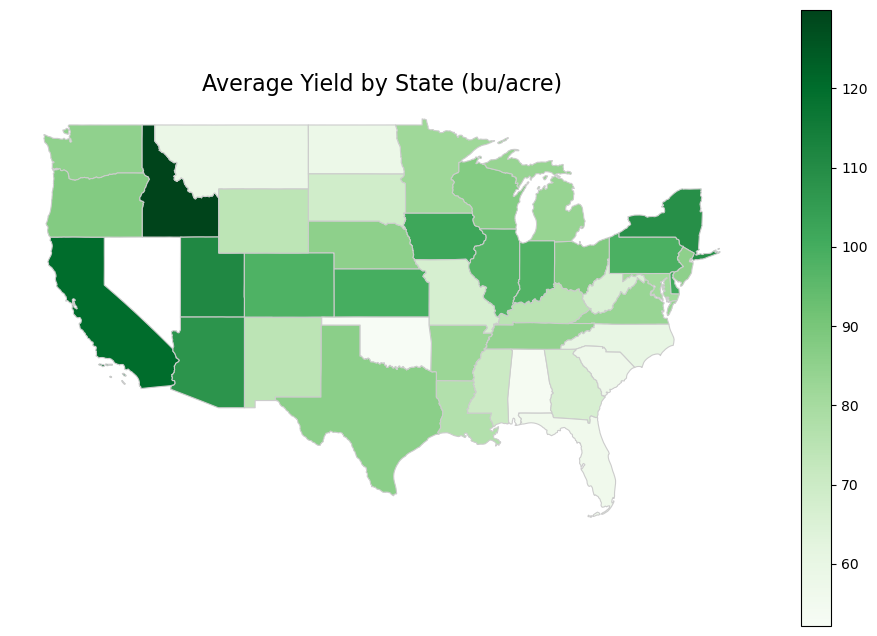

In [134]:
# Load US state shapefile
states = gpd.read_file("./data/cb_2018_us_state_20m.zip")

# Ensure consistent casing for merge
states['NAME'] = states['NAME'].str.upper()
state_avg_yield['state_name'] = state_avg_yield['state_name'].str.upper()

# Merging data
merged = states.merge(state_avg_yield, left_on='NAME', right_on='state_name')

# Plotting the average yield by state
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.plot(column='Yield', cmap='Greens', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax)
ax.set_title('Average Yield by State (bu/acre)', fontsize=16)
ax.axis('off')
plt.show()

In [135]:
# Looking at the stats of the yield values
df['Yield'].describe()

count    221556.000000
mean         81.045144
std          48.956958
min           0.000000
25%          40.000000
50%          73.600000
75%         114.600000
max         296.300000
Name: Yield, dtype: float64

Quite large std, indicating high variability of yield and a quarter of the data is below this value

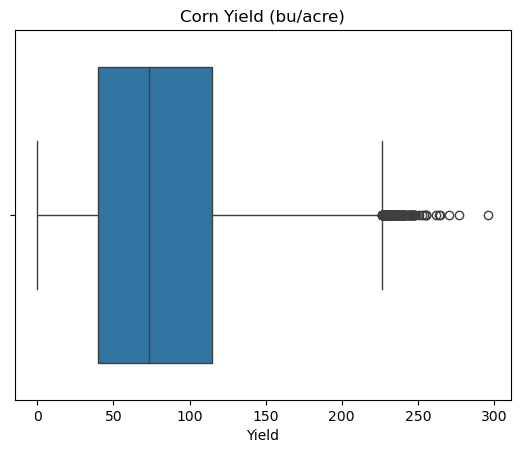

In [136]:
# Visualizing the distribution of corn yield values
sns.boxplot(df['Yield'], orient='h')
plt.title('Corn Yield (bu/acre)')
plt.show()

The majority of yields are clustered below 150 bu/acre, with a concentration in the 50–100 range <br>
There’s a long tail of exceptional yields, likely from regions or years with optimal conditions

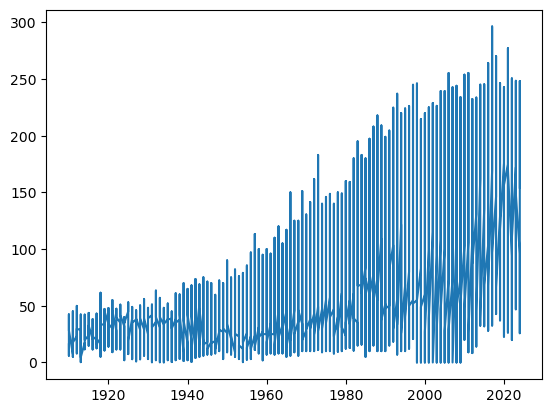

In [137]:
plt.plot(df['year'], df['Yield'])
plt.show()

From 1920 to 2020, there has been a sharp increase in yield values, suggesting steady growth, likely a sign of improved productivity due to technological advancements.
It is interesting to note that, since 1960, the values have begun to rise more rapidly, most likely due to significant advances in hybrid crops.
It is also evident that there are notable declines and peaks, which are likely related to weather conditions or other global events.

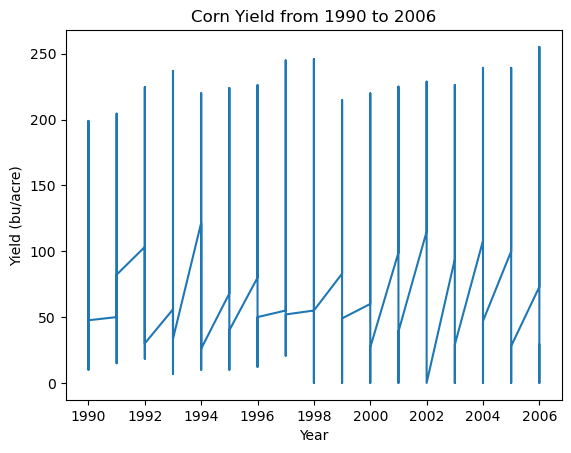

In [138]:
#Plotting the yield over specific years
df_filtered = df[(df['year'] >= 1990) & (df['year'] <= 2006)]
plt.plot(df_filtered['year'], df_filtered['Yield'])
plt.title('Corn Yield from 1990 to 2006')
plt.xlabel('Year')
plt.ylabel('Yield (bu/acre)')
plt.show()


In particular, between approximately 1990 and 2006, there were several locations with very low yields.

In [139]:
# Setting the index to 'year' for time series analysis for average yield
ts = year_mean.set_index('year')
ts_yield = pd.Series(ts['Yield'])

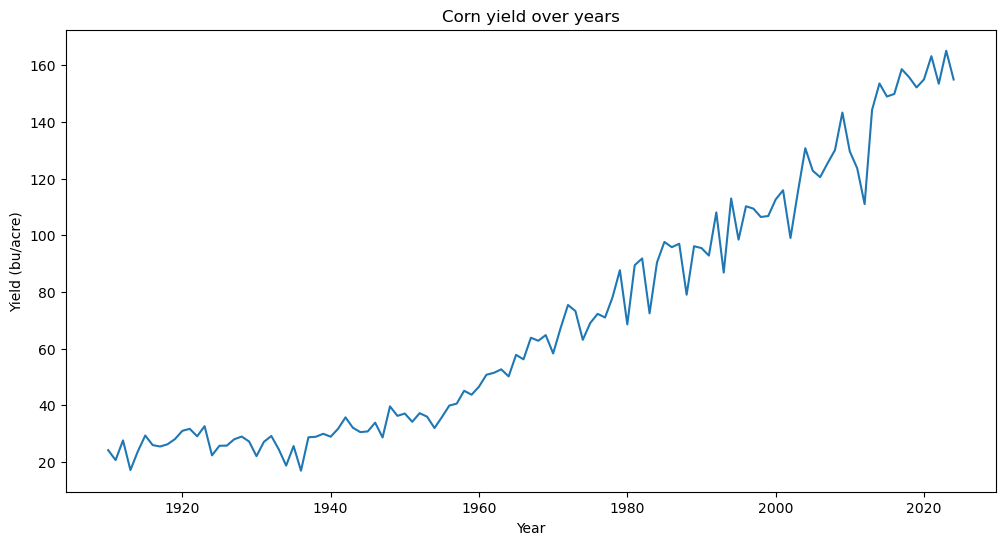

In [140]:
ts_yield.plot(legend=False, title='Corn yield over years', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Yield (bu/acre)')
plt.show()

In [141]:
# Calculating the average yield for each state
state_means = year_state_mean.groupby('state_name')['Yield'].mean()
# Finding the states with the highest and lowest average yield
top_state = state_means.idxmax()
bottom_state = state_means.idxmin()

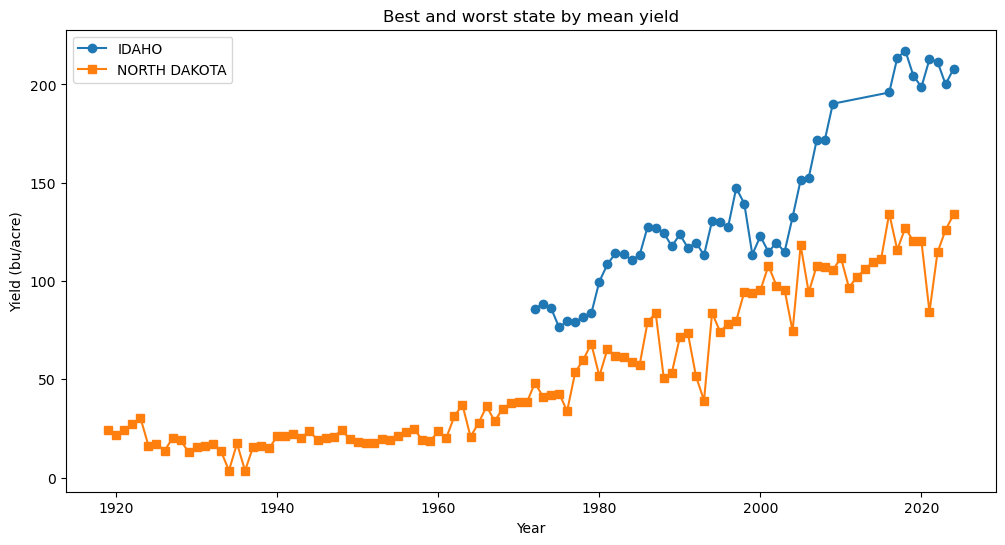

In [142]:
# Plotting the best and worst performing states by mean yield
top_data = year_state_mean[year_state_mean['state_name'] == top_state]
bottom_data = year_state_mean[year_state_mean['state_name'] == bottom_state]

plt.figure(figsize=(12, 6))
plt.plot(top_data['year'], top_data['Yield'], marker='o', label=top_state)
plt.plot(bottom_data['year'], bottom_data['Yield'], marker='s', label=bottom_state)

plt.title("Best and worst state by mean yield")
plt.xlabel("Year")
plt.ylabel("Yield (bu/acre)")
plt.legend()
plt.show()


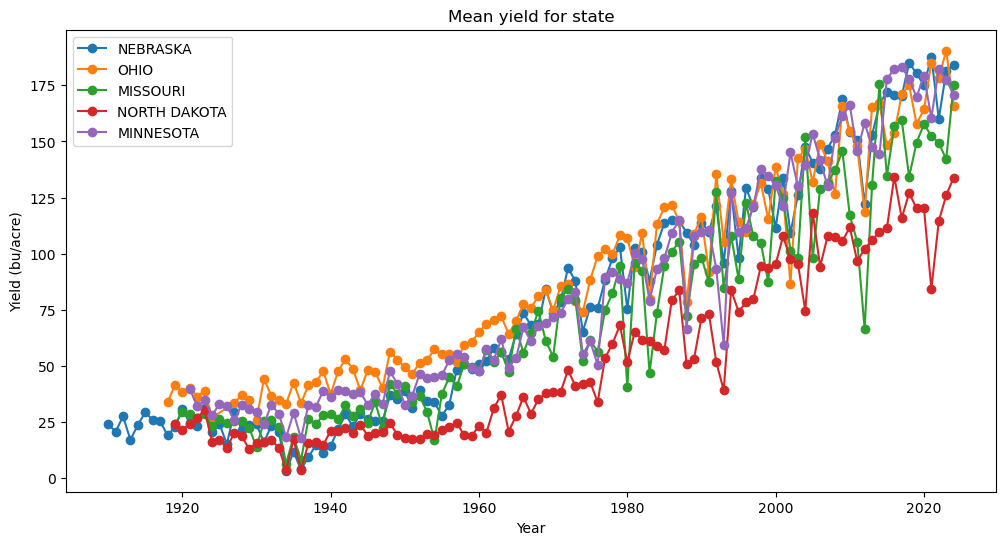

In [143]:
# Graph for the firts 10 states
states_to_plot = year_state_mean['state_name'].unique()[:5]  

plt.figure(figsize=(12, 6))
for state in states_to_plot:
    data = year_state_mean[year_state_mean['state_name'] == state]
    plt.plot(data['year'], data['Yield'], marker='o', label=state)

plt.title("Mean yield for state")
plt.xlabel("Year")
plt.ylabel("Yield (bu/acre)")
plt.legend()
plt.show()

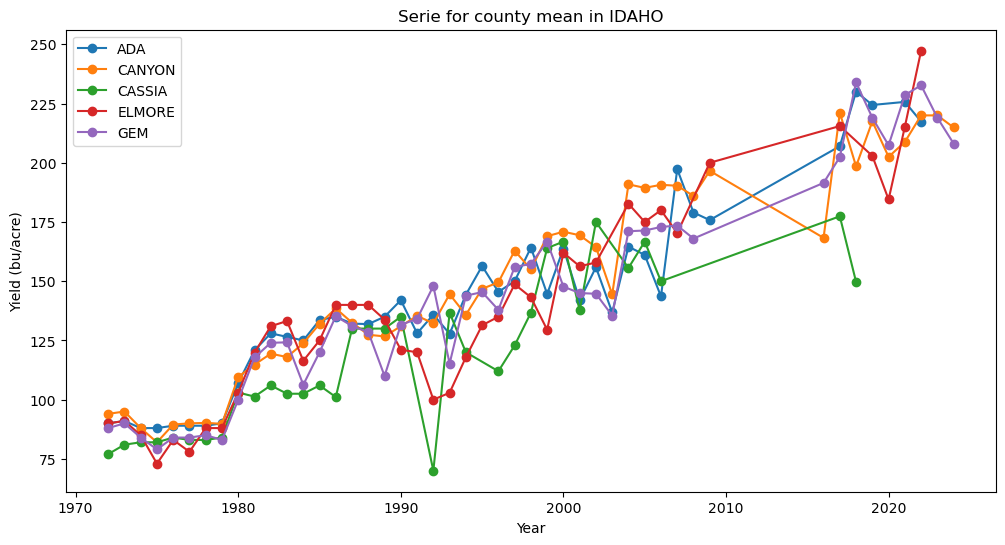

In [144]:
# Serie for county in a specific state
state_example = 'IDAHO'
county_time_series = df[df['state_name'] == state_example].groupby(['year', 'county_name'])['Yield'].mean().reset_index()

# Selecting some counties for the plot 
counties_to_plot = county_time_series['county_name'].unique()[:5]

plt.figure(figsize=(12, 6))
for county in counties_to_plot:
    data = county_time_series[county_time_series['county_name'] == county]
    plt.plot(data['year'], data['Yield'], marker='o', label=county)

plt.title(f"Serie for county mean in {state_example}")
plt.xlabel("Year")
plt.ylabel("Yield (bu/acre)")
plt.legend()
plt.show()

In the earlier years (1970–1980), the counties' values are closely grouped, but all counties exhibit a clear increasing trend in the variable over the decades.
Around 1991, CASSIA shows a sharp drop, while around 2022, ELMORE spikes to nearly 250, higher than the other counties. There also appears to be a gap between 2010 and 2016.

In [145]:
# Checking for the gap
df[df['state_name']== 'IDAHO'].groupby(['year', 'county_name'])['Yield'].mean().reset_index()['year'].unique()

array([1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024])

### Weather Data

In [146]:
# Reading the weather data
hist_wx_df = pd.read_parquet('./data/hist_wx_df.parquet')

In [147]:
# Displaying the first few rows of the weather data
hist_wx_df.head()

,aoi_id,date,tmax,tmin,precip,swvl1,swvl2,adm2_name,adm1_name
0,USA.14.100_1,2000-01-01,9.146448,-0.300685,0.000000,0.333584,0.316295,Will,Illinois
1,USA.14.100_1,2000-01-02,16.077440,4.774050,0.000000,0.343324,0.317686,Will,Illinois
2,USA.14.100_1,2000-01-03,9.560367,1.645247,0.466668,0.342535,0.320476,Will,Illinois
3,USA.14.100_1,2000-01-04,3.089767,-3.193717,1.183839,0.379731,0.338481,Will,Illinois
4,USA.14.100_1,2000-01-05,-1.597997,-8.902274,0.000000,0.353221,0.343165,Will,Illinois


In [148]:
# Displaying basic statistics of the weather data
hist_wx_df.describe().round(2)

,date,tmax,tmin,precip,swvl1,swvl2
count,8527402,8527402.00,8527402.00,8527402.00,8527402.00,8527402.00
mean,2012-03-02 03:27:13.931177984,16.46,6.88,2.36,0.32,0.32
min,2000-01-01 00:00:00,-32.29,-41.80,0.00,0.05,0.06
25%,2006-02-01 00:00:00,7.55,-1.34,0.00,0.27,0.26
50%,2012-03-03 00:00:00,17.97,7.70,0.00,0.34,0.33
75%,2018-04-02 00:00:00,26.25,16.38,1.50,0.38,0.38
max,2024-04-30 00:00:00,44.19,31.56,224.63,0.63,0.63
std,NaN,11.63,11.14,6.34,0.08,0.08


A solid standard deviation for temperature indicate noticeable variation across regions or seasons, extreme rainfall events do exist (max of 224.63)

In [149]:
# Checking for missing values in the weather data
hist_wx_df.isnull().sum()

aoi_id       0
date         0
tmax         0
tmin         0
precip       0
swvl1        0
swvl2        0
adm2_name    0
adm1_name    0
dtype: int64

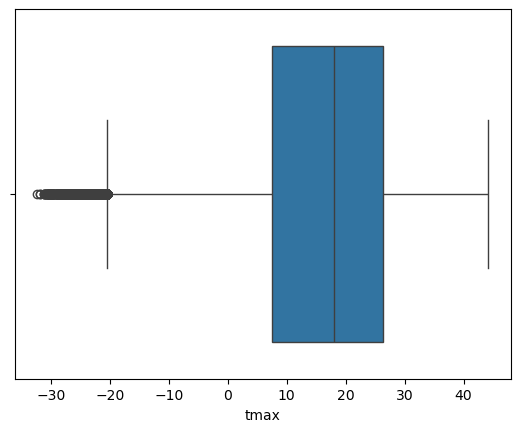

In [150]:
# Boxplot for temperature max
sns.boxplot(hist_wx_df['tmax'], orient='h')
plt.show()

There is a long tail toward very low values (outliers), which could represent measurement errors, anomalous data, or possibly extreme weather conditions.
I would expect these values to occur in winter; if not, I will remove them. 

In [151]:
# Checking for extreme temperature values
extr_temp = hist_wx_df[hist_wx_df['tmax'] < -20]
extr_temp = extr_temp.copy()

In [152]:
# Adding month and year columns for extreme temperature events
extr_temp['month'] = extr_temp['date'].dt.month
extr_temp['year'] = extr_temp['date'].dt.year

# Count how many extreme events per month
print(extr_temp['month'].value_counts().sort_index())


month
1     3436
2      882
3       21
12    1610
Name: count, dtype: int64


All the extreme events occur in winter, so they are not outliers that need to be removed for now.

[]

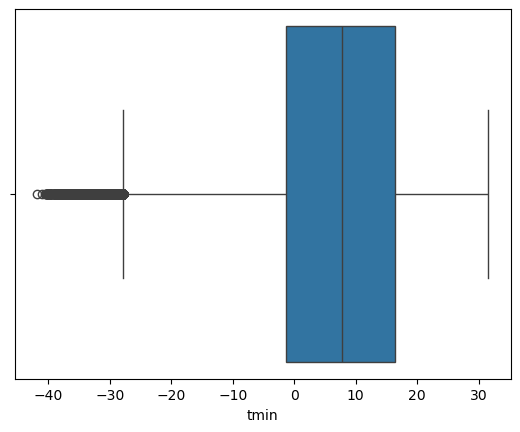

In [153]:
# Checking also for temperature min
sns.boxplot(hist_wx_df['tmin'], orient='h')
plt.plot()

In [154]:
extr_temp = hist_wx_df[hist_wx_df['tmin'] < -20]
extr_temp = extr_temp.copy()

# adding month and year columns for extreme temperature events
extr_temp['month'] = extr_temp['date'].dt.month
extr_temp['year'] = extr_temp['date'].dt.year

# Count how many extreme events per month
print(extr_temp['month'].value_counts().sort_index())

month
1     52983
2     39579
3      5269
4         4
10        8
11      242
12    23178
Name: count, dtype: int64


In this case too, low temperatures were recorded in winter, apart from four in April, which is plausible given the spring frosts.

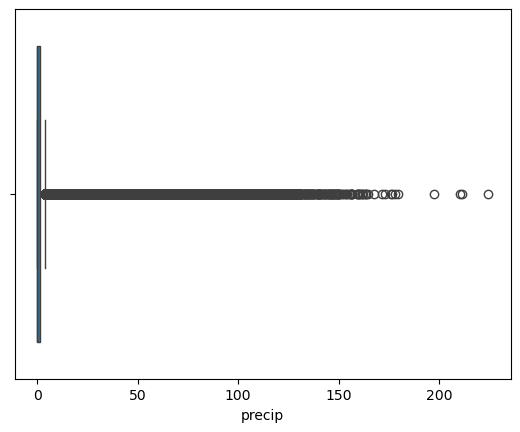

In [155]:
# Boxplot for precipitation
sns.boxplot(hist_wx_df['precip'], orient='h')
plt.show()

The box plot show clearly highlights a common problem in precipitation data, <br>
the presence of very high outliers and a strongly asymmetrical (skewed) distribution because there a lot of days without rain. <br>
There are several values at the limit, but it is probably an example of extreme weather behaviour, which could be useful for climate modelling or trend analysis.

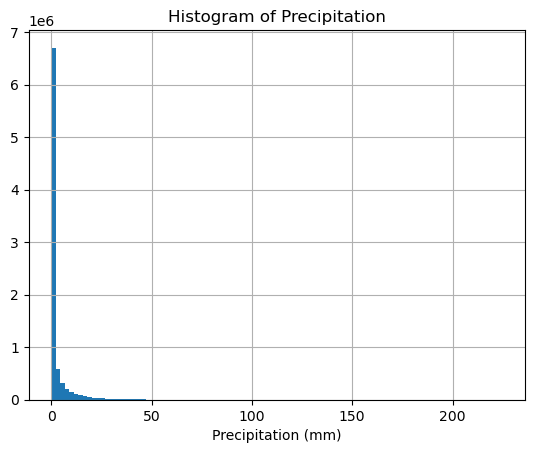

In [156]:
# Histogram for precipitation
hist_wx_df['precip'].hist(bins=100)
plt.title('Histogram of Precipitation')
plt.xlabel('Precipitation (mm)')
plt.show()

### Weather events

For unusual or specific events, I will aggregate the data by state and assess whether there are any corresponding events in terms of yield.

In [157]:
# Ensure datetime format
hist_wx_df['date'] = pd.to_datetime(hist_wx_df['date'])
hist_wx_df['year'] = hist_wx_df['date'].dt.year
hist_wx_df['month'] = hist_wx_df['date'].dt.month


My idea is to filter the weather data to the growing season—typically April to October in USA. I believe that weather outside the growing season (especially during months with the most extreme conditions, such as January to December) can introduce irrelevant or misleading inputs. Narrowing the focus to the physiologically active period helps increase the signal-to-noise ratio.


In [158]:
# Filter for growing season (April to October)
growing_season_df = hist_wx_df[hist_wx_df['month'].between(4, 10)]

# Aggregate weather by year
year_weather_summary = growing_season_df.groupby(
    ['year'], 
).agg(
    tmax_mean=('tmax', 'mean'),
    tmin_mean=('tmin', 'mean'),
    precip_sum=('precip', 'sum'),
    swvl1_mean=('swvl1', 'mean'),
    swvl2_mean=('swvl2', 'mean')
    
).reset_index()

# Aggregate weather by year and state
year_state_weather_summary = growing_season_df.groupby(
    ['year', 'adm1_name'], 
).agg(
    tmax_mean=('tmax', 'mean'),
    tmin_mean=('tmin', 'mean'),
    precip_sum_mean=('precip', 'mean'),
    swvl1_mean=('swvl1', 'mean'),
    swvl2_mean=('swvl2', 'mean')
    
).reset_index()

In [159]:
year_state_weather_summary.head()

,year,adm1_name,tmax_mean,tmin_mean,precip_sum_mean,swvl1_mean,swvl2_mean
0,2000,Illinois,24.604442,15.020123,3.093348,0.336009,0.335322
1,2000,Indiana,23.362436,13.952075,3.257541,0.336135,0.337944
2,2000,Iowa,23.715995,13.574263,2.508588,0.285794,0.277163
3,2000,Kansas,27.664892,16.325456,2.117374,0.235809,0.234743
4,2000,Kentucky,25.978824,16.301462,2.769042,0.359820,0.363367


In [160]:
year_weather_summary.head()

,year,tmax_mean,tmin_mean,precip_sum,swvl1_mean,swvl2_mean
0,2000,24.062811,14.027172,528880.740294,0.301953,0.299196
1,2001,23.833894,13.948437,594234.426030,0.311481,0.310350
2,2002,23.728914,13.847579,550877.451700,0.296724,0.292790
3,2003,23.465538,13.276669,548412.235936,0.302949,0.302303
4,2004,23.296945,13.535197,608889.084359,0.309207,0.307541


In [161]:
# Merge the dataframes of weather and state mean yield
year_state_weather_summary['adm1_name'] = year_state_weather_summary['adm1_name'].str.upper()

yield_weather_state = year_state_mean.merge(
    year_state_weather_summary,
    how='inner',
    left_on=['year', 'state_name'],
    right_on=['year', 'adm1_name']
)

In [162]:
# Calculate additional features
yield_weather_state['soil_moisture_delta'] = yield_weather_state['swvl1_mean'] - yield_weather_state['swvl2_mean']
yield_weather_state['term_stress'] = yield_weather_state['tmax_mean'] - yield_weather_state['tmin_mean']
yield_weather_state['dry_heat_index'] = (yield_weather_state['tmax_mean']) / (yield_weather_state['precip_sum_mean'] + 1) # adding one to avoid zero div 
yield_weather_state['tmax_mean_lag1'] = yield_weather_state['tmax_mean'].shift(1)
yield_weather_state['precip_sum_lag1'] = yield_weather_state['precip_sum_mean'].shift(1)
yield_weather_state['tmax_mean_3yr'] = yield_weather_state['tmax_mean'].rolling(window=3).mean()
yield_weather_state['precip_sum_3yr'] = yield_weather_state['precip_sum_mean'].rolling(window=3).mean()

In [163]:
yield_weather_state.columns

Index(['year', 'state_name', 'Yield', 'adm1_name', 'tmax_mean', 'tmin_mean',
       'precip_sum_mean', 'swvl1_mean', 'swvl2_mean', 'soil_moisture_delta',
       'term_stress', 'dry_heat_index', 'tmax_mean_lag1', 'precip_sum_lag1',
       'tmax_mean_3yr', 'precip_sum_3yr'],
      dtype='object')

In [164]:
# Feature to use in correlation analysis
features = yield_weather_state.columns.drop(['year', 'state_name', 'adm1_name'])

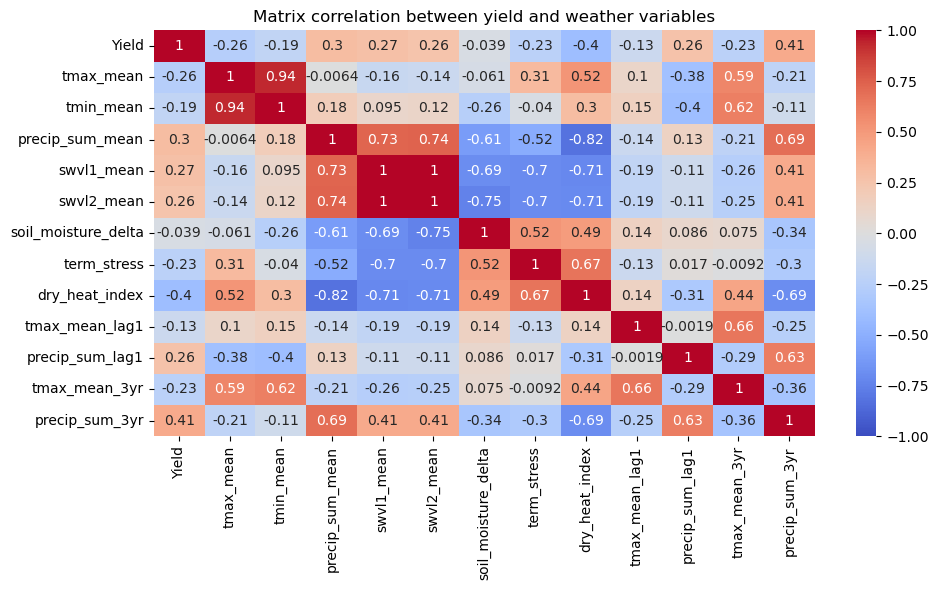

In [165]:
# Calculating the correlation matrix for the features
corr_matrix = yield_weather_state[features].corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrix correlation between yield and weather variables")
plt.tight_layout()
plt.show()

Now, to build a machine learning model to predict yield, we want features that have a strong correlation with yield but they shouldn't be too redundant with each other (to avoid multicollinearity).

For example:
- `swvl1_mean` and `swvl2_mean` are nearly identical, so we can use only one to avoid redundancy.
- `precip_sum_mean`, `precip_sum_3yr`, `precip_sum_lag1` are related but have different time scales, so they may add distinct info.
- `tmax_mean`, `tmax_mean_3yr`, `dry_heat_index`,`term_stress` are correlated with each other but represent different stress dimensions.


In [166]:
# Calculate additional features for the year weather summary
year_weather_summary['soil_moisture_delta'] = year_weather_summary['swvl1_mean'] - year_weather_summary['swvl2_mean']
year_weather_summary['term_stress'] = year_weather_summary['tmax_mean'] - year_weather_summary['tmin_mean']
year_weather_summary['dry_heat_index'] = (year_weather_summary['tmax_mean']) / (year_weather_summary['precip_sum'] + 1) # adding one to avoid zero div
year_weather_summary['tmax_mean_lag1'] = year_weather_summary['tmax_mean'].shift(1)
year_weather_summary['precip_sum_lag1'] = year_weather_summary['precip_sum'].shift(1)
year_weather_summary['tmax_mean_3yr'] = year_weather_summary['tmax_mean'].rolling(window=3).mean()
year_weather_summary['precip_sum_3yr'] = year_weather_summary['precip_sum'].rolling(window=3).mean()

In [167]:
weather_before_2024 = year_weather_summary[:-1] # Removing 2024 since the data is not complete

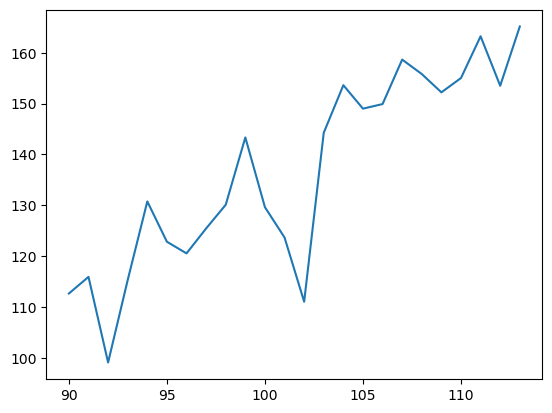

In [168]:
year_mean[(year_mean['year'] >= 2000) & (year_mean['year'] <= 2023)]['Yield'].plot() # plotting the yield from 2000 to 2023
plt.show()

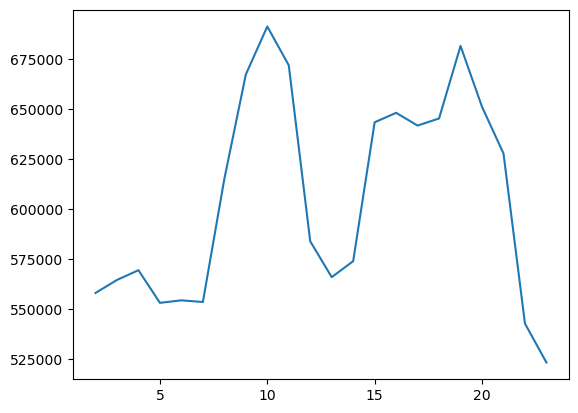

In [169]:
weather_before_2024['precip_sum_3yr'].plot()
plt.show()

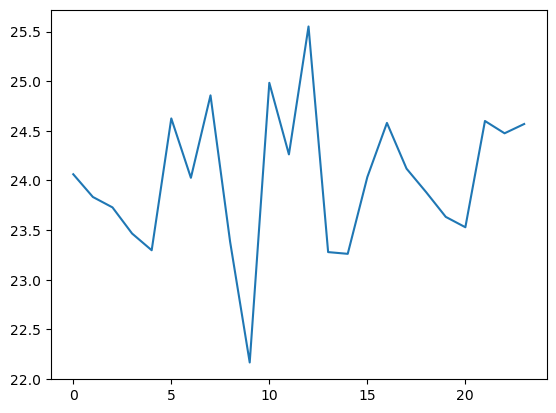

In [170]:
weather_before_2024['tmax_mean'].plot()
plt.show()

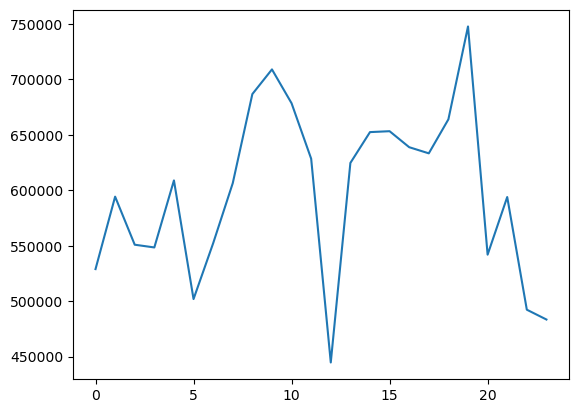

In [171]:
weather_before_2024['precip_sum'].plot()
plt.show()

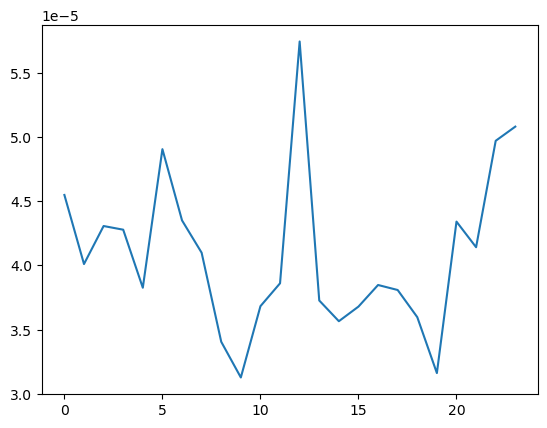

In [172]:
weather_before_2024['dry_heat_index'].plot()
plt.show()

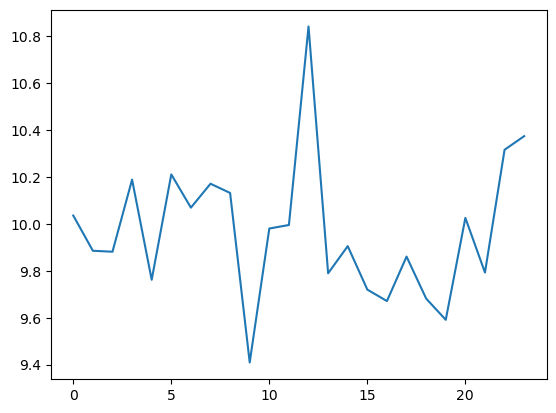

In [173]:
weather_before_2024['term_stress'].plot()
plt.show()

By closely analysing the weather data and yield for the period 2000-2023 (range provided for weather data), several things can be noted: <br>
- A sharp decrease in yield around 2012;<br>
- The decrease in yield coincides with a drastic drop in total rainfall; <br>
- Predictably, in addition to the decrease in rainfall, soil moisture also decreased. <br>
- During the same period, it can be observed that the average maximum temperatures were the highest (drought). <br>
- Average maximum temperatures around 25 degrees, combined with good rainfall/soil moisture, allowed for the best yields. <br>

Corn yield shows a positive relationship with water availability (rain and soil moisture) and a negative relationship with high temperatures, especially maximum temperatures.  <br>
This suggests that crops respond well to a temperate and humid climate, while excessive heat can penalise them, a classic effect of heat stress.

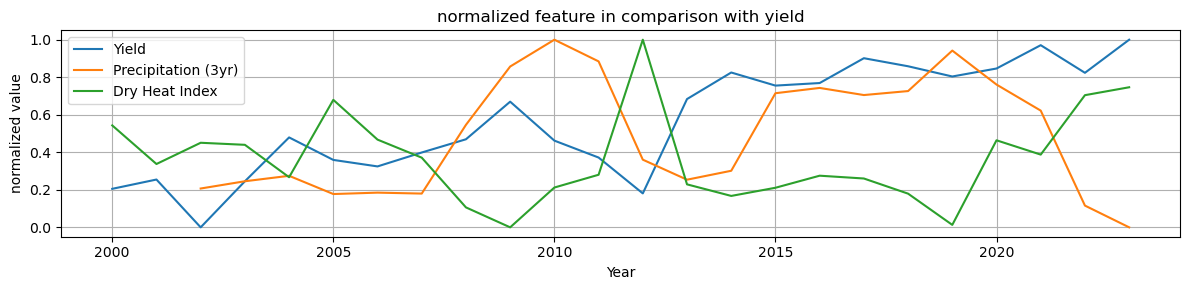

In [174]:
# Filter the first series between 2000 and 2023
filtered_value = year_mean[(year_mean['year'] >= 2000) & (year_mean['year'] <= 2023)][['year', 'Yield']].copy()

# Extract the other two series
precip = year_weather_summary[['year', 'precip_sum_3yr']].copy()
dry_heat_index = year_weather_summary[['year', 'dry_heat_index']].copy()

# Merge all series on 'year'
merged = filtered_value.merge(precip, on='year').merge(dry_heat_index, on='year')

# Normalize all value columns
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(merged[['Yield', 'precip_sum_3yr', 'dry_heat_index']])
normalized_df = pd.DataFrame(normalized_data, columns=['Yield', 'Precipitation (3yr)', 'Dry Heat Index'])
normalized_df['Year'] = merged['year']

# Plot the normalized series
plt.figure(figsize=(12, 3))
plt.plot(normalized_df['Year'], normalized_df['Yield'], label='Yield')
plt.plot(normalized_df['Year'], normalized_df['Precipitation (3yr)'], label='Precipitation (3yr)')
plt.plot(normalized_df['Year'], normalized_df['Dry Heat Index'], label='Dry Heat Index')
plt.xlabel('Year')
plt.ylabel('normalized value')
plt.title('normalized feature in comparison with yield')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Dry Heat Index appears negatively correlated with yield, especially in 2012, where a sharp spike in the dry heat index coincides with a yield drop (likely a drought year).In 2009–2011, lower dry heat corresponds to rising yield.

Precipitation rolling mean shows a positive correlation with yield in some periods (e.g., 2009–2011 and 2016–2020). In 2020–2023, precipitation drops, but yield remains high. This could suggest irrigation or agronomic adaptation.

## Model Development and Evaluation

The modeling approach followed these steps:

- I modeled using only the time series containing yield data since 1910, without including weather variables, to establish a reference baseline.
- I incorporated annual weather data using aggregated information.
- I built machine learning models using county-level data to increase the number of usable observations.
  
At this point, I faced a choice: either to use machine learning models that treat each observation independently, or to account for temporal order, since past values influence future ones. Since yield in the previous year is correlated with yield in the current year, I chose to treat the data as a time series in order to capture the dependence between past and future values of the same variable.

### Time series using yield from 1910

I applied a simple ARIMA model using only the historical yield data from 1910 for baseline forecasting, and also experimented with ARIMA incorporating weather features from 2000 onward. 

In [175]:
import warnings
warnings.filterwarnings("ignore")

In [176]:
# Creating a time series object for yield
ts = year_mean[['Yield']]
ts.index = pd.Index(range(1910, 2025), name='year')

In [177]:
print(ts.head())

          Yield
year           
1910  24.149462
1911  20.627957
1912  27.587097
1913  17.106452
1914  23.718280


In [178]:
ts = ts[:-1]  # Removing the last year (2024)

In [179]:
# Checking for null values
ts_yield.isna().sum()

np.int64(0)

In [180]:
# Test Dickey-Fuller for stationarity
result = adfuller(ts['Yield'])
print(f'p-value: {result[1]}')

# If p-value < 0.05, the series is stationary
if result[1] < 0.05:
    print("The series is stationary")
else:
    print("The series is not stationary, differencing is needed")


p-value: 0.9990633968161201
The series is not stationary, differencing is needed


In [181]:
# Lets use TimeSeriesSplit for cross-validation
y = ts['Yield']
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

errors = []

for train_index, test_index in tscv.split(y):
    train, test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit auto_arima to determine best (p,d,q)
    model = auto_arima(train, seasonal=False, stepwise=True, d=None, suppress_warnings=True)
    
    # Fit ARIMA with the best parameters
    arima_model = ARIMA(train, order=model.order)
    arima_fit = arima_model.fit()
    
    # Forecast the same number of steps as test set length
    forecast = arima_fit.forecast(steps=len(test))
    
    # Compute RMSE 
    rmse = np.sqrt(mean_squared_error(test, forecast))
    errors.append(rmse)
    print(f'Fold RMSE: {rmse:.4f}')

# Average cross-validated RMSE
print(f'\nAverage Cross-Validated RMSE: {np.mean(errors):.4f}')


Fold RMSE: 4.8718
Fold RMSE: 17.7429
Fold RMSE: 22.1195
Fold RMSE: 18.2652
Fold RMSE: 21.0382

Average Cross-Validated RMSE: 16.8075


In [182]:
# Fit the model with auto_arima to determine (p,d,q)
final_model = auto_arima(y, seasonal=False, stepwise=True, d=None)
best_model = ARIMA(y, order=final_model.order)
best_model_fit = best_model.fit()

# Forecast with confidence intervals 
forecast_result = best_model_fit.get_forecast(steps=1)
mean_forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)  # 95% CI

# Get standard deviation of the forecast 
forecast_std = np.sqrt(forecast_result.var_pred_mean)

# Output the forecast and the interval
print(f"Forecasted yield for 2024: {mean_forecast.iloc[0]:.2f}")
print(f"Standard deviation of forecast: {forecast_std.iloc[0]:.2f}")
print(f"95% Confidence Interval: [{conf_int.iloc[0, 0]:.2f}, {conf_int.iloc[0, 1]:.2f}]")


Forecasted yield for 2024: 166.45
Standard deviation of forecast: 6.89
95% Confidence Interval: [152.95, 179.95]


The performance metrics are adequate for exploratory forecasting, especially given the small dataset. The spread in fold RMSE highlights the need for robust validation and potentially more granular or diverse input features

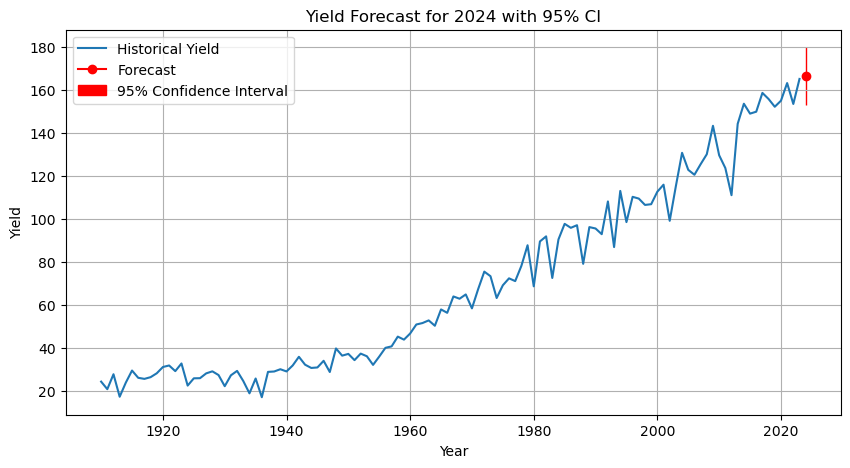

In [183]:
# Plot the time series and forecast
plt.figure(figsize=(10, 5))
plt.plot(y, label='Historical Yield')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast', color='red', marker='o')
plt.fill_between(mean_forecast.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='red', label='95% Confidence Interval')
plt.legend()
plt.title("Yield Forecast for 2024 with 95% CI")
plt.xlabel("Year")
plt.ylabel("Yield")
plt.grid(True)
plt.show()


### Time series using weather data

It is possible to insert also the weather data for a baseline yield estimation

In [184]:
# Prepare time series data and exogenous variables
ts = ts[ts.index > 1999]
interested_features = weather_before_2024.columns.drop(['year','tmax_mean_lag1', 'precip_sum_lag1', 'tmax_mean_3yr', 'precip_sum_3yr']) # dropping lagged features to avoid nan
X = weather_before_2024[interested_features]
X.index = pd.Index(range(2000, 2024), name='year')

# Ensure indices match
assert all(X.index == ts.index), "Indices of ts and X do not match"

# Walk-forward cross-validation
start_year = 2004
end_year = 2022
history_years = list(range(2000, start_year))  # initial training period

predictions = []
true_values = []

for year in range(start_year, end_year + 1):
    train_y = ts.loc[history_years]['Yield']
    train_X = X.loc[history_years]

    test_y = ts.loc[year]['Yield']
    test_X = X.loc[year:year]

    # Fit ARIMAX model
    model = ARIMA(train_y, exog=train_X, order=(1, 1, 2))
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=1, exog=test_X)
    predictions.append(forecast.iloc[0])
    true_values.append(test_y)

    # Expand the window
    history_years.append(year)

# Evaluation
rmse = np.sqrt(mean_squared_error(true_values, predictions))
print(f"Cross-Validation RMSE: {rmse:.2f} bu/acre")

# Print each prediction
for year, pred, true in zip(range(start_year, end_year + 1), predictions, true_values):
    print(f"{year}: predicted = {pred:.2f}, actual = {true:.2f}")


Cross-Validation RMSE: 60.98 bu/acre
2004: predicted = 97.17, actual = 130.75
2005: predicted = 17.09, actual = 122.82
2006: predicted = -44.10, actual = 120.53
2007: predicted = 107.39, actual = 125.43
2008: predicted = 300.12, actual = 130.09
2009: predicted = 143.78, actual = 143.34
2010: predicted = 155.70, actual = 129.62
2011: predicted = 137.52, actual = 123.65
2012: predicted = 107.92, actual = 111.02
2013: predicted = 131.68, actual = 144.27
2014: predicted = 138.18, actual = 153.62
2015: predicted = 148.68, actual = 149.01
2016: predicted = 143.08, actual = 149.91
2017: predicted = 146.93, actual = 158.66
2018: predicted = 165.16, actual = 155.82
2019: predicted = 167.47, actual = 152.21
2020: predicted = 146.01, actual = 155.03
2021: predicted = 151.46, actual = 163.25
2022: predicted = 156.70, actual = 153.51


In [185]:
# Creating input for ARIMAX for 2024
features_all_years = year_weather_summary[:-1]  # Removing the last year 2024 for the mean

# Calculate the mean of the features across all years
mean_row = features_all_years.mean(numeric_only=True)

# Convert the mean row to a DataFrame and select the interested features
mean_row_df = mean_row.to_frame().T
mean_row_df = mean_row_df[interested_features]

In [186]:
# Input for 2024
X_2024 = mean_row_df

In [187]:
# Fit the final ARIMAX model on all available data 
final_y = ts['Yield']
final_X = X

final_model = ARIMA(final_y, exog=final_X, order=(1, 1, 2))
final_model_fit = final_model.fit()

# Forecast for 2024 using the exogenous variables for 2024
forecast_result_2024 = final_model_fit.get_forecast(steps=1, exog=X_2024)

# Extract forecast mean, confidence interval, and std dev
mean_forecast_2024 = forecast_result_2024.predicted_mean.iloc[0]
conf_int_2024 = forecast_result_2024.conf_int(alpha=0.05).iloc[0]
forecast_std_2024 = np.sqrt(forecast_result_2024.var_pred_mean.iloc[0])

print(f"Forecasted yield for 2024: {mean_forecast_2024:.2f} bu/acre")
print(f"95% Confidence Interval: [{conf_int_2024[0]:.2f}, {conf_int_2024[1]:.2f}] bu/acre")
print(f"Standard deviation of forecast: {forecast_std_2024:.2f}")


Forecasted yield for 2024: 173.67 bu/acre
95% Confidence Interval: [159.25, 188.09] bu/acre
Standard deviation of forecast: 7.36


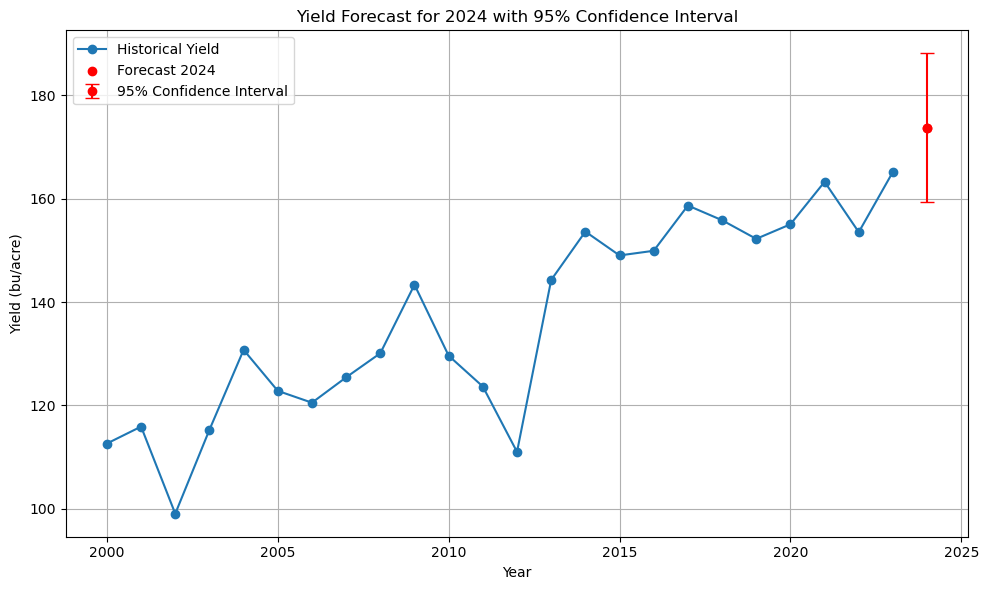

In [188]:
# Historical data (2000-2023)
years = final_y.index
yields = final_y.values

# Forecast point and CI for 2024
forecast_year = 2024
forecast_val = mean_forecast_2024
lower_ci = conf_int_2024[0]
upper_ci = conf_int_2024[1]

plt.figure(figsize=(10, 6))

# Plot historical yields
plt.plot(years, yields, label='Historical Yield', marker='o')

# Plot forecasted point for 2024
plt.scatter(forecast_year, forecast_val, color='red', label='Forecast 2024', zorder=5)

# Plot confidence interval as error bar
plt.errorbar(forecast_year, forecast_val,
             yerr=[[forecast_val - lower_ci], [upper_ci - forecast_val]],
             fmt='o', color='red', capsize=5, label='95% Confidence Interval')

plt.xlabel('Year')
plt.ylabel('Yield (bu/acre)')
plt.title('Yield Forecast for 2024 with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Although the estimate appears reasonable, the model's reliability is limited due to the small dataset for the data aggregation. For this reason I will use the granularity of the data at county level.

### ML models

We now know that USDA yield data is available annually at the county level from 1910 but weather data is available daily at the county level starting from 2000. 
To ensure consistency, I chose to use data from 2000 to 2023, where both datasets overlap and can be aggregated to the same spatial and temporal resolution.

I chosed these models:
- Linear Regression: as a baseline to capture straightforward, linear relationships between features and yield. 

- SVR, Random Forest, and XGBoost: for their ability to model non-linear patterns and complex interactions, which are crucial in this type of analysis, where agricultural data is influenced by weather variability and other non-linear dynamics.

#### Preparing Data

In [189]:
# Grouping the yield data by county and year to get the average yield
county_yield = df.groupby(['county_name', 'year'])['Yield'].mean().reset_index()

In [190]:
# Group by county and year, then aggregate
weather_year_county_agg = hist_wx_df.groupby(['adm2_name', 'year']).agg({
    'tmax': 'mean',
    'tmin': 'mean',
    'precip': 'mean',  
    'swvl1': 'mean',
    'swvl2': 'mean'
}).reset_index()

In [191]:
# Now we can add the weather features as we did for state to the county yield data
weather_year_county_agg['soil_moisture_delta'] = weather_year_county_agg['swvl1'] - weather_year_county_agg['swvl2']
weather_year_county_agg['term_stress'] = weather_year_county_agg['tmax'] - weather_year_county_agg['tmin']
weather_year_county_agg['dry_heat_index'] = (weather_year_county_agg['tmax']) / (weather_year_county_agg['precip'] + 1) # adding one to avoid zero div
weather_year_county_agg['tmax_mean_lag1'] = weather_year_county_agg['tmax'].shift(1)
weather_year_county_agg['precip_sum_lag1'] = weather_year_county_agg['precip'].shift(1)
weather_year_county_agg['tmax_mean_3yr'] = weather_year_county_agg['tmax'].rolling(window=3).mean()
weather_year_county_agg['precip_sum_3yr'] = weather_year_county_agg['precip'].rolling(window=3).mean()

In [192]:
# Fit the names to merge with county_yield
weather_year_county_agg['adm2_name'] = weather_year_county_agg['adm2_name'].str.upper()  

# Merging the weather data with the county yield data
df_county = weather_year_county_agg.merge(county_yield, left_on=['adm2_name', 'year'], right_on=['county_name', 'year'], how='inner')

# Dropping the 'adm2_name' column as it is not needed anymore
df_county.drop(columns=['adm2_name'], inplace=True)

In [193]:
df_county.columns

Index(['year', 'tmax', 'tmin', 'precip', 'swvl1', 'swvl2',
       'soil_moisture_delta', 'term_stress', 'dry_heat_index',
       'tmax_mean_lag1', 'precip_sum_lag1', 'tmax_mean_3yr', 'precip_sum_3yr',
       'county_name', 'Yield'],
      dtype='object')

In [194]:
# Droppin redundant columns
df_county.drop(columns=['swvl2', 'tmin','soil_moisture_delta', 'tmax_mean_lag1', 'tmax_mean_3yr'], inplace=True)

In [195]:
# Exclude year 2024 from the main dataset
df_county = df_county[df_county['year'] != 2024]  

### Data preprocessing

In [196]:
# Load the data
data = df_county.sort_values(by=['county_name', 'year'])  # Ensure data is sorted by time

# Handle missing values and target
X = data.drop(columns=['Yield'])
y = data['Yield']

# Define columns
categorical_columns = ['county_name', 'year']  
numerical_columns = X.columns.drop(categorical_columns)

# Create preprocessing pipelines
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_columns),
    ('cat', categorical_pipeline, categorical_columns)
])


Since the dataset is time-series shaped and the goal is to forecast the corn yield, I wanted to preserve the chronological order of the data. Using a classic k-fold cross-validation can lead to data leakage, where future information inadvertently enters the training set, something the model shouldn't see during learning. Therefore:

I preferred a time-based train-test split, training on historical data and validating on subsequent periods.

It is also possible to treat the variables are as independent observations, then a classic k-fold cross-validation can be used. In that case, while the predictive task is no longer a true forecast, it allows for stronger statistical validation on randomly shuffled samples.

In [197]:
# Time-based train-test split (last 20% for testing)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

### Create the input for the models

Since the 2024 weather data is not completly available, I used the mean values from the weather dataset. <br>
The historical mean provides a fast, stable, unbiased estimate.

In [198]:
# Group by county then aggregate for the mean 
year_2024 = hist_wx_df.groupby(['adm2_name']).agg({
    'tmax': 'mean',
    'tmin': 'mean',
    'precip': 'mean',   
    'swvl1': 'mean',
    'swvl2': 'mean'
}).reset_index()

# Adding the year column for the model
year_2024['year'] = 2024  
year_2024.rename(columns={'adm2_name': 'county_name'}, inplace=True)

# Calculate additional features for the year 2024
year_2024['soil_moisture_delta'] = year_2024['swvl1'] - year_2024['swvl2']
year_2024['term_stress'] = year_2024['tmax'] - year_2024['tmin']
year_2024['dry_heat_index'] = (year_2024['tmax']) / (year_2024['precip'] + 1) 
year_2024['tmax_mean_lag1'] = year_2024['tmax'].shift(1)
year_2024['precip_sum_lag1'] = year_2024['precip'].shift(1)
year_2024['tmax_mean_3yr'] = year_2024['tmax'].rolling(window=3).mean()
year_2024['precip_sum_3yr'] = year_2024['precip'].rolling(window=3).mean()

In [199]:
# Dropping the redundant columns
year_2024.drop(columns=['swvl2', 'tmin','soil_moisture_delta', 'tmax_mean_lag1', 'tmax_mean_3yr'], inplace=True)

### Linear Regression
Linear Regression is a simple model, assumes a linear relationship between the input features and the target variables. <br>
It provides uncertainty estimates through standard errors, confidence intervals, or prediction intervals, but these depend heavily on assumptions (linearity).

In [200]:
# --- Helper function ---
def prepare_data(X, fit=False):
    """Preprocess data with preprocessor (fit or transform)"""
    X_proc = preprocessor.fit_transform(X) if fit else preprocessor.transform(X)
    if hasattr(X_proc, "toarray"):
        X_proc = X_proc.toarray()
    return sm.add_constant(X_proc)  # Add intercept

# --- Time Series Cross-Validation ---
tscv = TimeSeriesSplit(n_splits=5)

lin_reg_r2_scores = []
lin_reg_mae_scores = []
lin_reg_mse_scores  = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"\n--- Fold {fold + 1} ---")

    # Split
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Preprocess
    X_train_design = prepare_data(X_train_cv, fit=True)
    X_test_design = prepare_data(X_test_cv, fit=False)

    # Fit model
    ols_model = sm.OLS(y_train_cv, X_train_design).fit()

    # Predict
    y_pred_test_cv = ols_model.predict(X_test_design)

    # Evaluate
    r2 = r2_score(y_test_cv, y_pred_test_cv)
    mae = mean_absolute_error(y_test_cv, y_pred_test_cv)
    mse = mean_squared_error(y_test_cv, y_pred_test_cv)

    # Store results
    lin_reg_r2_scores.append(r2)
    lin_reg_mae_scores.append(mae)
    lin_reg_mse_scores.append(mse)

    print(f"R²: {r2:.3f} | MAE: {mae:.2f} | MSE: {mse:.2f}")

# Collecting results
results_linear_regression = {
    'Average R²': np.mean(lin_reg_r2_scores),
    'Average MAE': np.mean(lin_reg_mae_scores),
    'Average MSE': np.mean(lin_reg_mse_scores)
}

# --- Summary ---
print("\n=== Linear Regression Cross-Validation Summary ===")
print(f"Average R²: {np.mean(lin_reg_r2_scores):.3f}")
print(f"Average MAE: {np.mean(lin_reg_mae_scores):.2f}")
print(f"Average MSE: {np.mean(lin_reg_mse_scores):.2f}")



--- Fold 1 ---
R²: 0.015 | MAE: 27.56 | MSE: 1218.68

--- Fold 2 ---
R²: 0.186 | MAE: 24.36 | MSE: 948.34

--- Fold 3 ---
R²: 0.141 | MAE: 24.49 | MSE: 954.12

--- Fold 4 ---
R²: 0.154 | MAE: 23.85 | MSE: 937.11

--- Fold 5 ---
R²: 0.079 | MAE: 26.27 | MSE: 1069.05

=== Linear Regression Cross-Validation Summary ===
Average R²: 0.115
Average MAE: 25.31
Average MSE: 1025.46


This low value points to weak linear associations between predictors and target, and suggests that key relationships may be non-linear or involve complex interactions

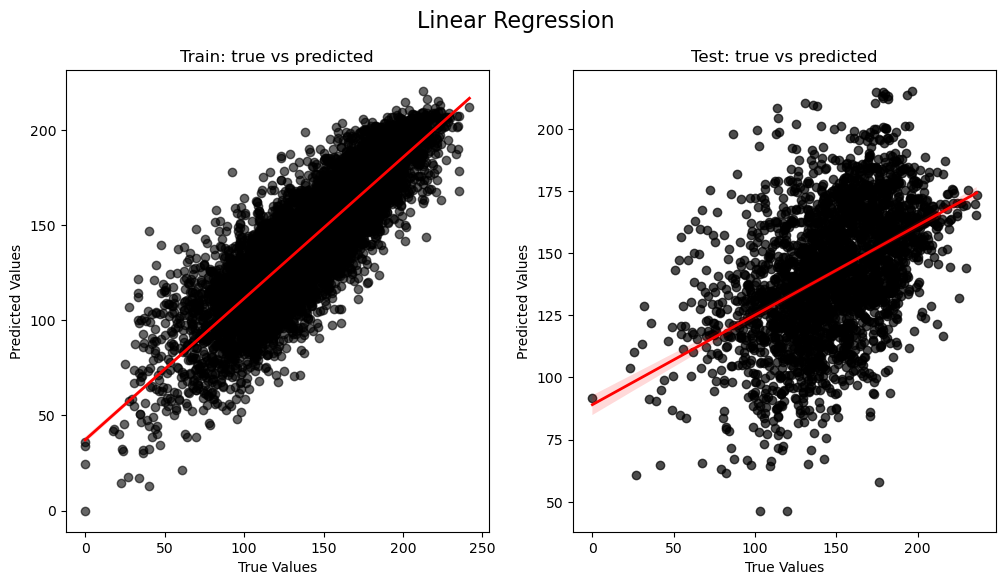

In [201]:
# Fit preprocessor on training data only
X_train_design = prepare_data(X_train, fit=True)

# Transform test data using the same preprocessor
X_test_design = prepare_data(X_test, fit=False)

# Fit model on training data
ols_model = sm.OLS(y_train, X_train_design).fit()

# Predict
y_pred_train = ols_model.predict(X_train_design)
y_pred_test = ols_model.predict(X_test_design)

# Plotting train vs test predictions
plt.figure(figsize=(12, 6))

# Training set plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, color='black', alpha=0.6)
sns.regplot(x=y_train, y=y_pred_train, scatter=False, color='red', line_kws={"lw":2})
plt.title('Train: true vs predicted')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Test set plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.7, color='black')
sns.regplot(x=y_test, y=y_pred_test, scatter=False, color='red', line_kws={"lw":2})
plt.title('Test: true vs predicted')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

plt.suptitle('Linear Regression', fontsize=16)
plt.show()

In [202]:
# Preprocess 2024 data
X_2024_design = prepare_data(year_2024, fit=False)

# Get prediction results (includes uncertainty)
pred_2024_results = ols_model.get_prediction(X_2024_design)

# Get full prediction summary (includes mean, std err, CI, PI)
pred_2024_summary = pred_2024_results.summary_frame(alpha=0.05)  # 95% CI

# Extract mean prediction
mean_pred = pred_2024_summary['mean'].mean()

# Summary of the prediction results
pred_summary = pred_2024_results.summary_frame(alpha=0.05)

# Standard deviation of the prediction interval
# The standard deviation is calculated as the width of the prediction interval divided by 2 * 1.96 (for 95% CI)
std_pred = (pred_summary['obs_ci_upper'] - pred_summary['obs_ci_lower']) / (2 * 1.96)

results_linear_regression.update({
    'Mean Yield Prediction': mean_pred,
    'Standard Deviation': std_pred.mean()})

# Results
print(f"\n=== Linear Regression 2024 yield Prediction ===")
print(f"Mean Yield Prediction: {mean_pred:.2f} bu/acre")
print(f"Standard Deviation: {std_pred.mean():.2f} bu/acre")


=== Linear Regression 2024 yield Prediction ===
Mean Yield Prediction: 137.43 bu/acre
Standard Deviation: 17.79 bu/acre


### Random Forest Regressor

In [215]:
# Pipeline for Random Forest Regression
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42, max_depth=15, min_samples_split=2, min_samples_leaf=1))
])

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

r2_scores = []
mae_scores = []
mse_scores = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"\n--- Fold {fold + 1} ---")
    
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Train model on this fold
    model_pipeline.fit(X_train_cv, y_train_cv)

    # Predict
    y_pred_cv = model_pipeline.predict(X_test_cv)

    # Evaluate
    r2 = r2_score(y_test_cv, y_pred_cv)
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    mse = mean_squared_error(y_test_cv, y_pred_cv)

    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)

    print(f"R²: {r2:.3f} | MAE: {mae:.2f} | MSE: {mse:.2f}")

results_random_forest = {
    'Average R²': np.mean(r2_scores),
    'Average MAE': np.mean(mae_scores),
    'Average MSE': np.mean(mse_scores)}

# --- Summary ---
print("\n=== Random Forest Cross-Validation Summary ===")
print(f"Average R²: {np.mean(r2_scores):.3f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average MSE: {np.mean(mse_scores):.2f}")



--- Fold 1 ---
R²: 0.421 | MAE: 20.62 | MSE: 715.94

--- Fold 2 ---
R²: 0.476 | MAE: 18.88 | MSE: 610.76

--- Fold 3 ---
R²: 0.477 | MAE: 18.84 | MSE: 580.75

--- Fold 4 ---
R²: 0.484 | MAE: 18.41 | MSE: 572.11

--- Fold 5 ---
R²: 0.537 | MAE: 18.27 | MSE: 537.43

=== Random Forest Cross-Validation Summary ===
Average R²: 0.479
Average MAE: 19.00
Average MSE: 603.40


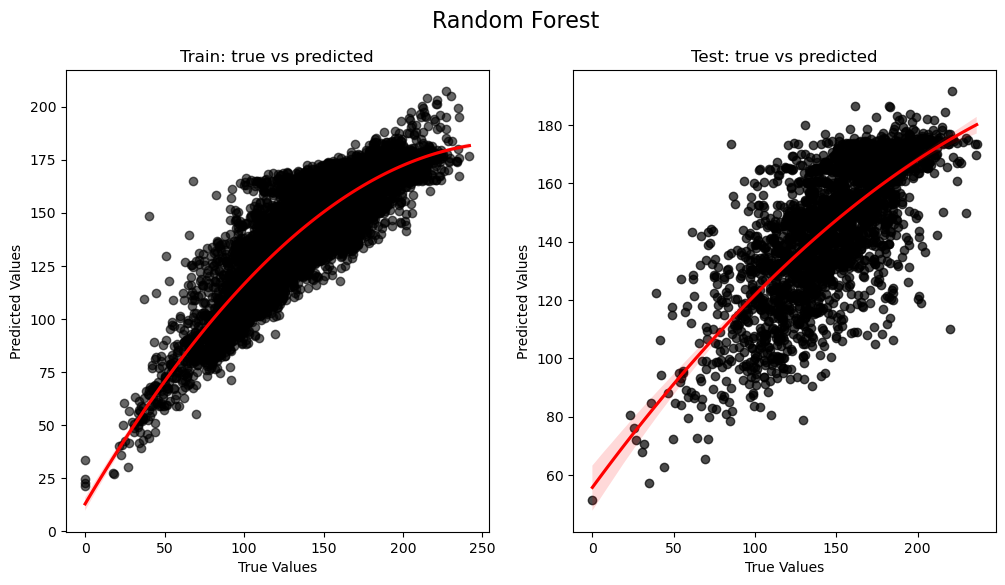

In [216]:
# Refit model on full training set
model_pipeline.fit(X_train, y_train)

# Predict on full training and test sets
y_train_pred = model_pipeline.predict(X_train)
y_pred = model_pipeline.predict(X_test)

# Plotting train vs test predictions
plt.figure(figsize=(12, 6))

# Plot for training set
plt.subplot(1, 2, 1)
sns.regplot(x=y_train, y=y_train_pred, scatter_kws={'color': 'black', 'alpha':0.6}, line_kws={'color': 'red'}, order=2)
plt.title('Train: true vs predicted')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot for test set
plt.subplot(1, 2, 2)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'color': 'black', 'alpha':0.7}, line_kws={'color': 'red'}, order=2)
plt.title('Test: true vs predicted')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

plt.suptitle('Random Forest', fontsize=16)
plt.show()

In [221]:
# Fit Random Forest
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42, max_depth=15, min_samples_split=2, min_samples_leaf=1))
])
rf.fit(X_train, y_train)

# Get prediction from each tree
model = rf.named_steps['model']
X_2024_transformed = rf.named_steps['preprocessor'].transform(year_2024)

tree_preds = np.array([tree.predict(X_2024_transformed) for tree in model.estimators_])
mean_pred = tree_preds.mean()
std_pred = tree_preds.std()

results_random_forest.update({
    'Mean Yield Prediction': mean_pred,
    'Standard Deviation': std_pred
})

print(f"\n=== Random Forest 2024 yield Prediction ===")
print(f"Mean Prediction: {mean_pred:.2f} bu/acre")
print(f"Standard Deviation: {std_pred:.2f} bu/acre")


=== Random Forest 2024 yield Prediction ===
Mean Prediction: 151.75 bu/acre
Standard Deviation: 21.62 bu/acre


The Random Forest has relatively large spread, signaling that while the average forecast is solid, individual predictions vary considerably. This suggests that the model captures non-linearities and local effects, but lacks tight consistency across all test cases.
To improve models and generalisation, various strategies can be applied, such as reducing model complexity, e.g. by limiting the maximum depth of trees.

### XGBoost

In [206]:
# Define XGBoost regression model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='reg:squarederror'
    ))
])

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

r2_scores = []
mae_scores = []
mse_scores = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"\n--- Fold {fold + 1} ---")
    
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Train model
    model_pipeline.fit(X_train_cv, y_train_cv)

    # Predict
    y_pred_cv = model_pipeline.predict(X_test_cv)

    # Evaluate
    r2 = r2_score(y_test_cv, y_pred_cv)
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    mse = mean_squared_error(y_test_cv, y_pred_cv)

    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)

    print(f"R²: {r2:.3f} | MAE: {mae:.2f} | MSE: {mse:.2f}")

# Results summary
results_xgboost = {
    'Average R²': np.mean(r2_scores),
    'Average MAE': np.mean(mae_scores),
    'Average MSE': np.mean(mse_scores)
}

print("\n=== XGBoost Cross-Validation Summary ===")
print(f"Average R²: {results_xgboost['Average R²']:.3f}")
print(f"Average MAE: {results_xgboost['Average MAE']:.2f}")
print(f"Average MSE: {results_xgboost['Average MSE']:.2f}")



--- Fold 1 ---
R²: 0.440 | MAE: 20.24 | MSE: 692.88

--- Fold 2 ---
R²: 0.489 | MAE: 18.69 | MSE: 595.99

--- Fold 3 ---
R²: 0.478 | MAE: 18.82 | MSE: 579.47

--- Fold 4 ---
R²: 0.491 | MAE: 18.35 | MSE: 564.38

--- Fold 5 ---
R²: 0.534 | MAE: 18.43 | MSE: 541.12

=== XGBoost Cross-Validation Summary ===
Average R²: 0.486
Average MAE: 18.91
Average MSE: 594.77


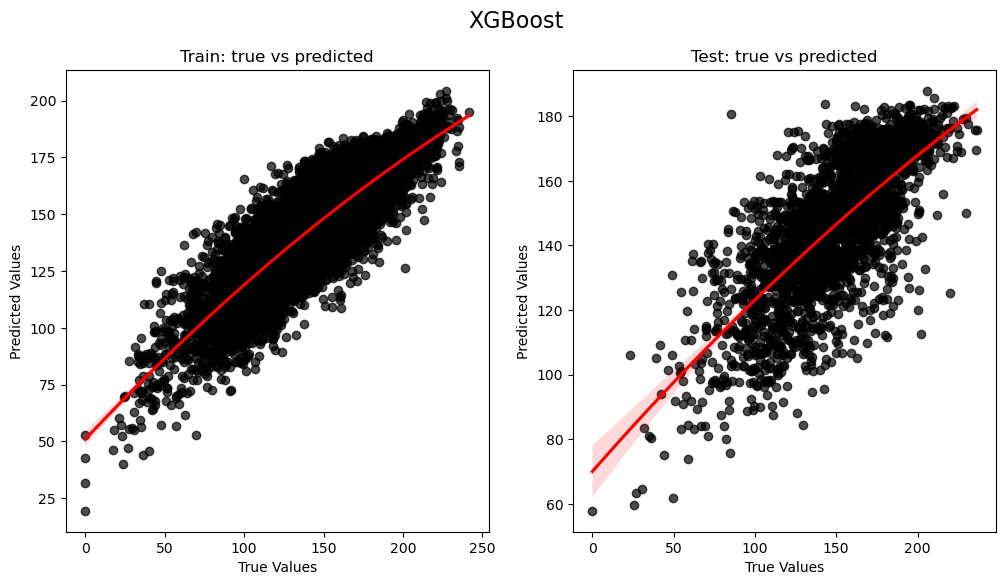

In [207]:
# Refit model on full training set
model_pipeline.fit(X_train, y_train)

# Predict on full training and test sets
y_train_pred = model_pipeline.predict(X_train)
y_pred = model_pipeline.predict(X_test)

# Plotting train vs test predictions
plt.figure(figsize=(12, 6))

# Plot for training set
plt.subplot(1, 2, 1)
sns.regplot(x=y_train, y=y_train_pred, scatter_kws={'color': 'black', 'alpha':0.7}, line_kws={'color': 'red'}, order=2)
plt.title('Train: true vs predicted')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot for test set
plt.subplot(1, 2, 2)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'color': 'black', 'alpha':0.7}, line_kws={'color': 'red'}, order=2)
plt.title('Test: true vs predicted')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

plt.suptitle('XGBoost', fontsize=16)
plt.show()

XGBoost doesn't naturally provide uncertainty estimates. We can be assessed uncertaintly indirectly by using additional techniques like bootstrapping

In [208]:
# Bootstrap for uncertainty estimation with XGBoost
n_bootstraps = 10
predictions = []

for i in range(n_bootstraps):
    # Bootstrap sample
    X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=i)

    # Fit XGBoost model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=i,
            objective='reg:squarederror'
        ))
    ])
    model.fit(X_resampled, y_resampled)

    # Predict for 2024
    pred = model.predict(year_2024)[0]
    predictions.append(pred)

# Aggregate predictions
predictions = np.array(predictions)
mean_prediction = predictions.mean()
std_prediction = predictions.std()

# Save results
results_xgboost.update({
    'Mean Yield Prediction': mean_prediction,
    'Standard Deviation': std_prediction
})

# Output results
print(f"\n=== XGBoost 2024 Yield Prediction (Bootstrap) ===")
print(f"Mean Yield Prediction: {mean_prediction:.2f} bu/acre")
print(f"Standard Deviation: {std_prediction:.2f} bu/acre")


=== XGBoost 2024 Yield Prediction (Bootstrap) ===
Mean Yield Prediction: 150.09 bu/acre
Standard Deviation: 4.52 bu/acre


### Support Vector Regression (SVR)


In [209]:
# Define SVR model pipeline
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVR(kernel='rbf', C=100, epsilon=0.1))
])

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

r2_scores = []
mae_scores = []
mse_scores = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"\n--- Fold {fold + 1} ---")

    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Train on current fold
    svr_pipeline.fit(X_train_cv, y_train_cv)

    # Predict
    y_pred_cv = svr_pipeline.predict(X_test_cv)

    # Evaluate
    r2 = r2_score(y_test_cv, y_pred_cv)
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    mse = mean_squared_error(y_test_cv, y_pred_cv)

    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)

    print(f"R²: {r2:.3f} | MAE: {mae:.2f} | MSE: {mse:.2f}")

results_svr = {
    'Average R²': np.mean(r2_scores),   
    'Average MAE': np.mean(mae_scores),
    'Average MSE': np.mean(mse_scores)
    }

# --- Summary ---
print("\n=== SVR Cross-Validation Summary ===")
print(f"Average R²: {np.mean(r2_scores):.3f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average MSE: {np.mean(mse_scores):.2f}")


--- Fold 1 ---
R²: 0.434 | MAE: 20.47 | MSE: 700.38

--- Fold 2 ---
R²: 0.522 | MAE: 18.10 | MSE: 557.55

--- Fold 3 ---
R²: 0.485 | MAE: 18.63 | MSE: 571.64

--- Fold 4 ---
R²: 0.539 | MAE: 17.61 | MSE: 510.66

--- Fold 5 ---
R²: 0.548 | MAE: 18.02 | MSE: 524.64

=== SVR Cross-Validation Summary ===
Average R²: 0.506
Average MAE: 18.57
Average MSE: 572.98


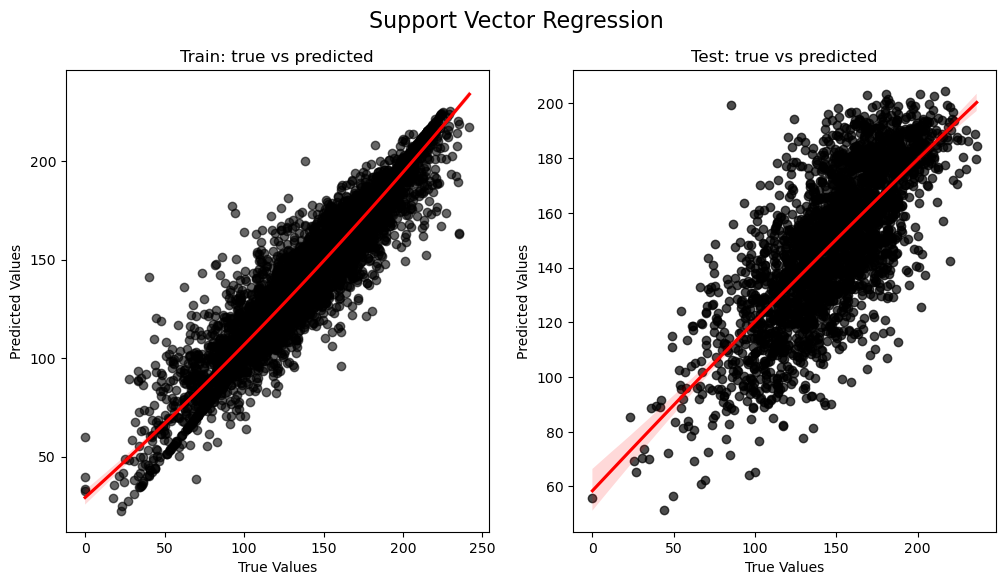

In [210]:
# Refit on full training data
svr_pipeline.fit(X_train, y_train)

# Predict on training and test data
y_train_pred_svr = svr_pipeline.predict(X_train)
y_pred_svr = svr_pipeline.predict(X_test)

# Plotting train vs test predictions
plt.figure(figsize=(12, 6))

# Plot for training set
plt.subplot(1, 2, 1)
sns.regplot(x=y_train, y=y_train_pred_svr, scatter_kws={'color': 'black', 'alpha':0.6}, line_kws={'color': 'red'}, order=2)
plt.title('Train: true vs predicted')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot for test set
plt.subplot(1, 2, 2)
sns.regplot(x=y_test, y=y_pred_svr, scatter_kws={'color': 'black', 'alpha':0.7}, line_kws={'color': 'red'}, order=2)
plt.title('Test: true vs predicted')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

plt.suptitle('Support Vector Regression', fontsize=16)
plt.show()

SVR doesn't naturally provide uncertainty estimates because it’s primarily focused on finding a decision boundary where errors are tolerated. 
We can be assessed uncertaintly indirectly by using additional techniques like bootstrapping

In [211]:
# Bootstrap for uncertainty estimation for SVR 
n_bootstraps = 10 
predictions = []

for i in range(n_bootstraps):
    # Bootstrap sample
    X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=i)

    # Fit model (use e.g. SVR or ElasticNet)
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', SVR())  # or ElasticNet()
    ])
    model.fit(X_resampled, y_resampled)

    # Predict 2024
    pred = model.predict(year_2024)[0]  
    predictions.append(pred)

predictions = np.array(predictions)
mean_prediction = predictions.mean()
std_prediction = predictions.std()

results_svr.update({
    'Mean Yield Prediction': mean_prediction,
    'Standard Deviation': std_prediction
})

# Predicting for 2024 using the SVR model
print(f"\n=== SVR  2024 yield Prediction ===")
print(f"Mean Yied Prediction: {mean_pred:.2f} bu/acre")
print(f"Standard Deviation: {std_pred:.2f} bu/acre")


=== SVR  2024 yield Prediction ===
Mean Yied Prediction: 154.36 bu/acre
Standard Deviation: 32.10 bu/acre


## Reporting

Combining all the results togheter for evaluation

In [222]:
# Combine the results into a single dictionary
all_results = {
    'Support Vector Regression': results_svr,
    'Random Forest': results_random_forest,
    'XGBoost': results_xgboost,
    'Linear Regression': results_linear_regression
}

In [223]:
metrics_df = pd.DataFrame(all_results)

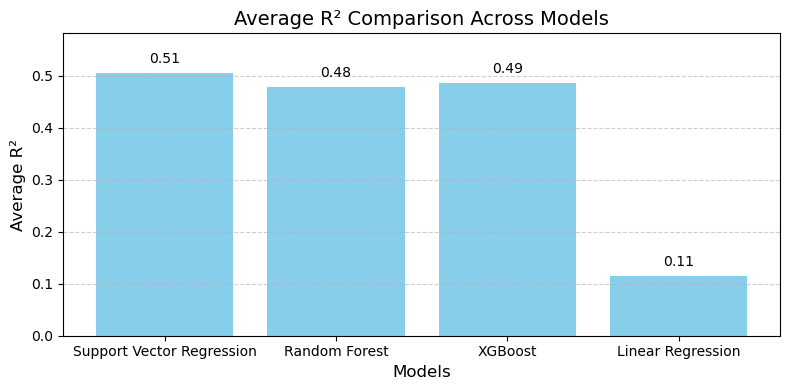

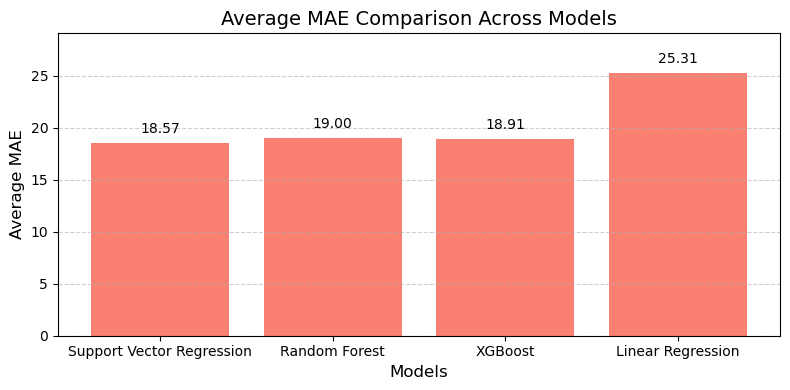

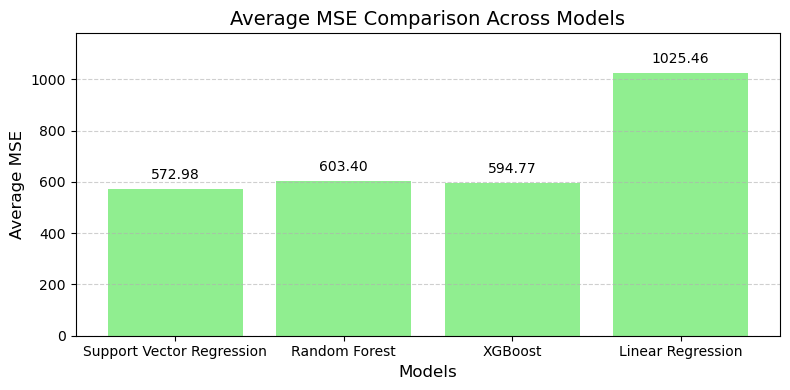

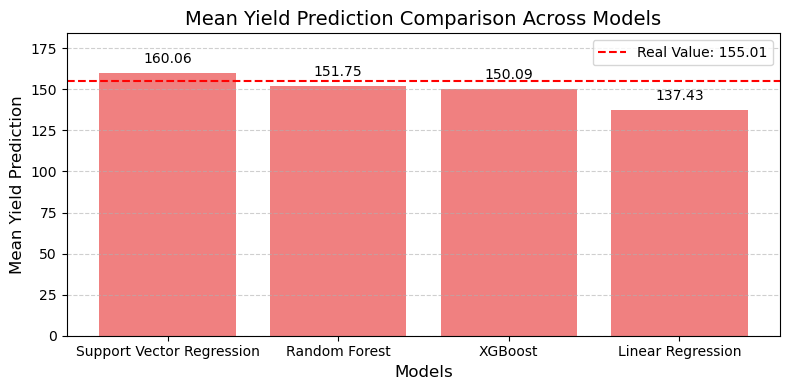

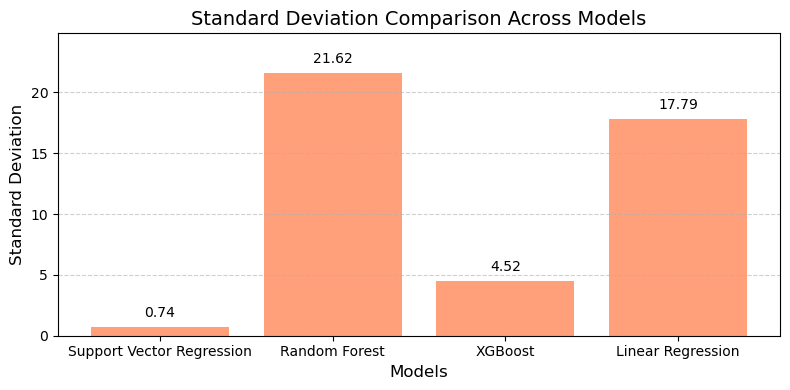

In [224]:
# Individual metrics to plot
metrics_to_plot = metrics_df.index
colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'lightsalmon']
real_value = year_mean['Yield'].iloc[-1].round(2)

for i, metric in enumerate(metrics_to_plot):
    fig, ax = plt.subplots(figsize=(8, 4))
    
    values = metrics_df.loc[metric]
    bars = ax.bar(values.index, values.values, color=colors[i])
    
    # Adding annotations
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
        
    # Adding 'Mean Prediction'
    if metric == 'Mean Yield Prediction':
        ax.axhline(real_value, color='red', linestyle='--', linewidth=1.5, label=f'Real Value: {real_value}')
        ax.legend()
        
    ax.set_ylim(0, max(values.values) * 1.15)
    ax.set_title(f'{metric} Comparison Across Models', fontsize=14)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xlabel('Models', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

The task involved nonlinear patterns (weather + yield), and SVR seems to be finding a balance between bias and variance.

- **Support Vector Regression (SVR)** demonstrates the strongest overall performance. It has the highest R², indicating better variance capture, along with low MAE and MSE for precise predictions. Its very low standard deviation suggests stable, consistent outputs.

- **XGBoost** comes close behind, offering robust accuracy with solid R² and low error metrics. It's particularly adept at handling feature interactions and regularization, although it underestimates slightly. Its moderate standard deviation shows a good balance of consistency and flexibility.

- **Random Forest** yields the closest mean prediction to the actual yield, but lower R² and high standard deviation imply less consistent modeling of nonlinearities. It seems to favor average proximity over deep accuracy.

- **Linear Regression** lags in performance. Low R² and high error metrics signal that its simplicity doesn’t capture the intricate relationships within the data.